<a href="https://colab.research.google.com/github/lcniell123/deepGenerative/blob/main/PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


**PixelCNN implementation for the course Deep Generative Models from Digital. Tech Academy.**


---



**Dataset & dataloaders**

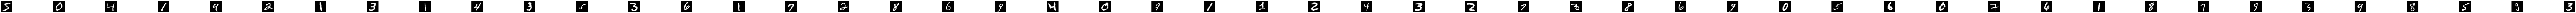

In [ ]:
# Import the required libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Define the transform to be applied to the data
# Transform is a composition of multiple transformations
# Here, only one transformation is applied which is ToTensor()
# It converts a PIL (Python Imaging Library) Image or numpy.ndarray in the range [0, 255]
# to a torch.FloatTensor in the range [0.0, 1.0]
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 256 # batch size

# Download and load the MNIST dataset
# root : root directory of dataset where processed/training.pt etc reside
# train : if True, creates dataset from training.pt, otherwise creates from test.pt
# download : if true, downloads the dataset from the internet and puts it in root directory
# transform : a function/transform that takes in an PIL image and returns a transformed version
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Uncomment to use FashionMNIST dataset
# trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a data loader to load the dataset in batches
# dataset : dataset from which to load the data
# batch_size : how many samples per batch to load
# shuffle : set to True to have the data reshuffled at every epoch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


# Import the required libraries for plotting
import matplotlib.pyplot as plt
# This line of code imports the numpy library, which is a powerful library for working with arrays and matrices in Python.
# It provides a wide range of mathematical and logical functions, as well as tools for working with arrays and matrices.
# The "np" is just an alias or nickname for the library, so it can be referenced more easily in the code.
import numpy as np

num_pictures =50						# Plot the first 10 images from the dataset
plt.figure(figsize=(450,2))	# Create a new figure. The figsize parameter is used to set the size of the figure in inches, in this case (20,5).
for i in range(num_pictures):
	# img is the i-th image of the dataset
	img = trainset[i][0]
	# Create a subplot of 1 row and num_pictures columns
	ax = plt.subplot(1,num_pictures,i+1)
	# Make x-axis and y-axis not visible
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
	# Plot the image
	# This code is taking an image that is stored as a tensor and first transferring it from GPU memory to CPU memory,
	# then removes the dimensions of size 1 from the tensor, converting the tensor to a numpy array,
	# so it can be displayed using the imshow() function from matplotlib library using 'gist_gray' colormap.
	# When displaying an image using Matplotlib's imshow() function, the image must be in the format of a 2D numpy array,
	# where the first dimension represents the height and the second dimension represents the width of the image.
	# However, when working with image data in PyTorch, the image is typically represented as a 3D tensor,
	# where the first dimension is the batch size, the second dimension is the height, and the third dimension is the width.
	# The .squeeze() it's used to remove the single-dimensional entries from the shape of an array.
	# This is useful when the tensor has an extra dimension of size 1, which is often the case when working with image data.
	plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
plt.show()

**Model architecture**

In [ ]:
# This code imports two modules from the PyTorch library:
# torch.nn : This module contains classes for defining and training neural networks.
# It contains many common layers and functions that are used in neural networks.
# torch.nn.functional : This module contains a large number of neural network functions, which are not necessarily associated
# with a particular model. These functions are generally used as building blocks for defining models.
import torch.nn as nn
import torch.nn.functional as F

# This code is checking if a CUDA-enabled GPU is available, and if so, it sets the variable device to "cuda:0" which means
# it will use the GPU with index 0 for computation, otherwise it sets the variable device to "cpu" which means it will use the CPU for computation.
# The torch.cuda.is_available() function checks if a CUDA-enabled GPU is available on the machine. If it returns True,
# it means that a GPU is available and can be used for computation, otherwise it returns False and computation will be performed on the CPU.
# The torch.device() function is used to specify on which device the tensors should be allocated.
# In this case, the code uses the torch.device() function to specify that the computation should be performed on the GPU if one is available,
# otherwise it will be performed on the CPU. This allows the code to take advantage of the faster computation speeds provided by a GPU
# if one is available, while still being able to run on machines that only have a CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

layers = 8 		# Number of layers in the network
kernel = 7 		# Kernel size
channels = 64 # Depth of the intermediate layers

# This is a custom class that is inheriting from the PyTorch class "nn.Conv2d". The "nn.Conv2d" class is a 2D convolutional layer,
# and the "MaskedCNN" class adds functionality for masking certain weights to the standard convolutional layer.
class MaskedCNN(nn.Conv2d):
	"""
	Taken from https://github.com/jzbontar/pixelcnn-pytorch
	"""
	def __init__(self, mask_type, *args, **kwargs):
		self.mask_type = mask_type
		assert mask_type in ['A', 'B'], "Unknown Mask Type"
		# Mask
		#         -------------------------------------
		#        |  1       1       1       1       1 |
		#        |  1       1       1       1       1 |
		#        |  1       1    1 if B     0       0 |   H // 2
		#        |  0       0       0       0       0 |   H // 2 + 1
		#        |  0       0       0       0       0 |
		#         -------------------------------------
		#  index    0       1     W//2    W//2+1

		super(MaskedCNN, self).__init__(*args, **kwargs)
			# Creating a buffer mask which is a copy of the weight data
			# This line of code creates a buffer called mask that stores the same data as the self.weight.data tensor but with a separate memory location.
			# This buffer can be accessed like any other attribute of the module and it is included in the state_dict when the model is saved.
			# self.mask is a 4-dimensional tensor with dimensions representing batch, channel, height and width.
		self.register_buffer('mask', self.weight.data.clone())
			# This line of code is using tuple unpacking to assign the size of each dimension of the self.weight tensor to a variable.
			# The self.weight.size() function returns a tuple containing the size of each dimension of the tensor.
		_, depth, height, width = self.weight.size()
		self.mask.fill_(1)  # the tensor is being filled with the value of 1
		if mask_type =='A':
				# specific values of the mask set to zero
				# : in the first dimension select all elements in the batch dimension.
				# : in the second dimension select all elements in the channel dimension.
				# height//2 in the third dimension select all elements from the middle of the height dimension.
				# width//2:] in the fourth dimension select all elements from the middle of the width dimension.
			self.mask[:,:,height//2,width//2:] = 0
				# : in the first dimension select all elements in the batch dimension.
				# : in the second dimension select all elements in the channel dimension.
				# height//2+1: in the third dimension select all elements from the middle of the height dimension + 1 and the rest of the
				# elements in the height dimension.
				# : in the fourth dimension select all elements in the width dimension.
			self.mask[:,:,height//2+1:,:] = 0
		else:
			self.mask[:,:,height//2,width//2+1:] = 0
			self.mask[:,:,height//2+1:,:] = 0


	def forward(self, x):
		self.weight.data*=self.mask # Applying the mask to the weights before forwarding
		return super(MaskedCNN, self).forward(x)

# The PixelCNN is used to create the neural network. It is defined as a subclass of the nn.Module class from the PyTorch library.
class PixelCNN(nn.Module):
	def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
		super(PixelCNN, self).__init__()
		self.no_layers = no_layers
		self.kernel = kernel
		self.channels = channels
		self.layers = {}
		self.device = device

		self.MaskAConv = nn.Sequential( # Creating a sequential module called "MaskAConv"
			MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False), 	# Initializing a MaskedCNN module with "A" mask, 1 input channel,
																																		# specified number of output channels, kernel size, stride of 1 and padding
																																		# of kernel//2, bias=False to not include bias term
			nn.BatchNorm2d(channels), 	# Applying batch normalization
			nn.ReLU(True) 							# Applying ReLU activation
		)

		MaskBConv = []
		for i in range(8):
			MaskBConv.append(MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False))
			MaskBConv.append(nn.BatchNorm2d(channels))
			MaskBConv.append(nn.ReLU(True))

		self.MaskBConv = nn.Sequential(*MaskBConv)

		self.out = nn.Conv2d(channels, 256, 1)	#"channels"  represents the number of input channels for the convolutional layer.
																						#"256"  represents the number of output channels for the convolutional layer.
																						# "1"  represents the kernel size of the convolutional layer.

	def forward(self, x):
		x = self.MaskAConv(x)
		x = self.MaskBConv(x)
		return self.out(x)





model = PixelCNN().to(device)	# Create an instance of the PixelCNN model, and assign it to the variable 'model'.
                          		# The 'to(device)' function is used to move the model to a specified device like GPU if available,
                          		# it is used to perform computations on the model using the specified device.

print(model)     # Show the model architecture

PixelCNN(
  (MaskAConv): Sequential(
    (0): MaskedCNN(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (MaskBConv): Sequential(
    (0): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedCNN(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): Batch

**Optimizer and loss function**

In [ ]:
# Import the torch.optim module, which contains various optimization algorithms, and assigns it to the variable "optim".
# This allows the user to call various optimization functions such as Adam, SGD, etc from the optim module using the "optim" variable.
import torch.optim as optim

#Initialize the optimizer with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Define the loss function as Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

**Sampling**

In [ ]:
# Import the math module. The module contains various mathematical functions and constants
# such as trigonometric functions, logarithmic functions, and the constant pi.
import math

no_images = 5 # Number of images to generate
images_size = 10 # Size of each image
images_channels = 1 # Number of channels in the image

#Function for generating and displaying the images
def sampling():
	model.eval() # Set the model to evaluation mode
	sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device) #Create a tensor to store the generated images
	sample.fill_(0) # Fill the tensor with 0s

  #Generating images pixel by pixel
	for i in range(images_size):
		for j in range(images_size):
			out = model(sample)
			probs = F.softmax(out[:,:,i,j], dim=-1).data	# Get the probability distribution of the output.
																										# F.softmax function to calculate the probabilities for the output at a specific location (i,j)
																										# The dim=-1 argument specifies that the softmax should be applied to the last dimension of the tensor.
																										# The .data attribute is used to extract the underlying data of the tensor and convert it to a numpy ndarray.
			sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0 # This line of code is using the torch.multinomial function from the PyTorch library to sample from
																																		# a probability distribution represented by the input tensor probs.
																																		# The function takes the input tensor, and samples a single value from it according to
																																		# the probabilities of each element in the tensor. The argument 1 passed to
																																		# torch.multinomial indicates that we want to sample one value. The output of this function
																																		# is a tensor of size 1 that contains the index of the sampled value.
																																		# The result is then divided by 255.0 to normalize the values to be between 0 and 1.


	plt.figure(figsize=(10,10))  # Create a figure with specified size
	for i in range(no_images):
		ax = plt.subplot(1,no_images,i+1)
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		plt.imshow(transforms.ToPILImage()(sample[i,:,:,:]), interpolation="bicubic",cmap='gist_gray') #This line of code is using the plt.imshow function from
																	# matplotlib library to display an image. It is displaying the i-th image from the sample tensor which is 4-dimensional tensor.
																	# The transforms.ToPILImage() function is used to convert the tensor to a PIL (Python Imaging Library) image object,
																	# which can be displayed using matplotlib's imshow function.
																	# The interpolation="bicubic" argument is used to specify the interpolation method for resampling the image.
																	# The cmap='gist_gray' argument is used to set the colormap of the image to grayscale.

	plt.show()

**Training**

In [ ]:
# Import tqdm library
from tqdm import tqdm #tqdm is a library for creating progress bars in the command line interface (CLI) for Python.

#number of epochs for training
num_epochs = 100

print("Training Started")	# Start the training
for epoch in range(num_epochs):  # Loop over the dataset multiple times
		model.train()		# The model is set to training mode, which enables any operations that are specific to the training mode.
		running_loss = 0.0
		pbar = tqdm(enumerate(trainloader, 0), total=int(len(trainset) / trainloader.batch_size))
		for i, data in pbar:
				# Get the inputs; data is a list of [inputs, labels]
				inputs, _ = data

				target = (inputs[:, 0, :, :] * 255).long()  # The input tensor is a 4-dimensional tensor with the shape (batch_size, channels, height, width).
																										# It means it's selecting all the images of the first channel from the input tensor,
																										# multiplying them by 255, and casting them to a long datatype.

				inputs = inputs.to(device)	# Move the inputs tensor from its current location to a specific device
				target = target.to(device)	# Move the inputs tensor from its current location to a specific device

				# Zero the parameter gradients
				optimizer.zero_grad()	# Before the optimizer updates the parameters, the gradients need to be zeroed out so that the optimizer can calculate
															# the new gradients for the current iteration. This is because the gradients are accumulated across iterations,
															# which can cause the optimizer to update the parameters in a direction that is not correct.

				# Forward + backward + optimize
				outputs = model(inputs)	# Calculation of the model's output
				loss = criterion(outputs, target)	# calculation of the loss between the model's output and the target using a criterion function.
				loss.backward()		# computation of the gradients of the loss with respect to the model's parameters. This is done using the "backward" method on the loss tensor.
				optimizer.step()	# updates of the model's parameters. This step will update the model's parameters in the direction that reduces the loss.

				# Print statistics
				running_loss += loss.item()	# Accumulate the loss
				pbar.set_description(f'epoch: {epoch + 1} of {num_epochs}, loss: {running_loss/(i+1):.3f}')	# print the current epoch, the total epochs
																																																		# and the average of the losses

		# Show samples
		sampling()

print('Training Finished')	# Training finished

########################################################################
#save trained model:
PATH = './savedModel.pth'
torch.save(model.state_dict(), PATH)

Training Started


NameError: ignored